### Libraries

In [1]:
import os
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import re
import collections
import string
import math
%matplotlib inline

### Read data

In [2]:
filename = './data/prepr_train.csv'
train_data_ = pd.read_csv(filename)
print ('Data size:', len(train_data_))
train_data_.head()

Data size: 3947


,Insult,Date,Comment
0,1,20120618192155Z,you fuck your dad
1,0,20120528192215Z,i really do not understand your point xa it se...
2,0,NaN,a xc xa majority of canadians can and has been...
3,0,NaN,listen if you dont wanna get married to a man ...
4,0,20120619094753Z,c xe c b u ea n xu u ed ng u u b u eddng bi u ...


In [3]:
filename = './data/prepr_valid.csv'
valid_data_ = pd.read_csv(filename)
print ('Data size:', len(valid_data_))
valid_data_.head()

Data size: 2647


,Insult,Date,Comment,Usage
0,0,NaN,the drudge report n n n nyou wo not see this s...,PublicTest
1,0,20120618222256Z,ian xa roger clemens is the fucking man and ne...,PublicTest
2,1,20120618213617Z,agree with alan you are an extremest idiot you...,PublicTest
3,0,NaN,really <SIGNS> n ni see marc lamont hill on va...,PrivateTest
4,0,20120620003825Z,really suck is not the word when many of our n...,PrivateTest


In [4]:
filename = './data/prepr_test.csv'
test_data_ = pd.read_csv(filename)
print ('Data size:', len(test_data_))
test_data_.head()

Data size: 2235


,Insult,Date,Comment
0,0,20120603163526Z,like this if you are a tribe fan
1,1,20120531215447Z,you idiot
2,1,20120823164228Z,i am a woman babs and the only war on women i ...
3,1,20120826010752Z,wow you benefitted so many wins this year from...
4,1,20120602223825Z,haha green me red you now loser whos winning n...


In [5]:
train_data = train_data_
valid_data = valid_data_
test_data = test_data_
                               
valid_size = len(valid_data)
train_size = len(train_data)
test_size = len(test_data)

X_train = train_data['Comment']
y_train = train_data['Insult']
X_valid = valid_data['Comment']
y_valid = valid_data['Insult']
X_test = test_data['Comment']
y_test = test_data['Insult']

### Compose vocabulary

In [6]:
vocabulary_size = 50000

def build_vocabulary(words):
    counter_words = collections.Counter(words)
    count = [['UNK', -3], ['<EOS>', 0], ['<PAD>', 0], ['<SIGNS>', counter_words['<SIGNS>']]]
    count.extend(counter_words.most_common(vocabulary_size - 4))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

words = ' '.join(X_train)
print ('Length of train data in words:', len(words))

data, count, dictionary, reverse_dictionary = build_vocabulary(words.split(' '))
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])

print ('Dict:', dictionary['UNK'])
print ('Reverse dict:', reverse_dictionary[0])
print ('Counter:', count[dictionary['UNK']])
print ('Data:', data[0])
print ('Words:', words[:10])
del words

Length of train data in words: 728927
Most common words (+UNK) [['UNK', 0], ['<EOS>', 0], ['<PAD>', 0], ['<SIGNS>', 1747], ('the', 4780)]
Sample data [5, 74, 19, 688, 10, 98, 23, 13, 256, 19]
Dict: 0
Reverse dict: UNK
Counter: ['UNK', 0]
Data: 5
Words: you fuck y


### Word indexing

In [7]:
def word2id(word):
    if word in dictionary:
        return dictionary[word]
    else:
        return 0 # UNK

def id2word(id_):
    return reverse_dictionary[id_]


def comment2vec(comment):
    global comment_size
    split = comment.split(' ')
    res = np.array([word2id(word) for word in split], dtype='int')
    return res

def vec2comment(vec):
    global comment_size
    return ' '.join([id2word(id_) for id_ in vec])


### Generation of batches

In [8]:
class LabeledBatchGenerator(object):
    def __init__(self, comments, batch_size, comment_size, labels):
        self._comments = comments
        self._num_comments = len(comments)
        self._batch_size = batch_size
        self._comment_size = comment_size
        self._labels = labels
        segment = self._num_comments // batch_size
        self._cursor = [offset * segment for offset in range(batch_size)]
        
    def _next_batch(self, step):
        batch = np.zeros(shape=(self._batch_size,1), dtype=np.int)
        for b in range(self._batch_size):
            comment = comment2vec(self._comments[self._cursor[b]])
            N = len(comment)
            if step < N:
                batch[b,0] = comment[step]
            elif step == N:
                batch[b,0] = word2id('<EOS>')
            elif step > N:
                batch[b,0] = word2id('<PAD>')
            if step == self._comment_size - 1:
                if N > self._comment_size - 1:
                    batch[b,0] = word2id('<EOS>')
                self._cursor[b] = (self._cursor[b] + 1) % self._num_comments
        return batch
    
    def next(self):
        batches = []
        batches_labels = [self._labels[self._cursor[b]] for b in range(self._batch_size)]
        for step in range(0, self._comment_size):
            batches.append(self._next_batch(step))
        return batches, batches_labels

In [9]:
comment_size = 100
batch_size = 64

train_batch_generator = LabeledBatchGenerator(X_train.as_matrix(), batch_size, comment_size, y_train.as_matrix())
valid_batch_generator = LabeledBatchGenerator(X_valid.as_matrix(), batch_size, comment_size, y_valid.as_matrix())
test_batch_generator = LabeledBatchGenerator(X_test.as_matrix(), batch_size, comment_size, y_test.as_matrix())

In [10]:
def plot_results(losses_, mean_losses_, train_aucs_, valid_aucs_, frequency):
    plt.figure(figsize=(18,6))
    plt.plot(losses_)
    plt.title('Losses')
    plt.xlabel('Step')
    plt.show()
    plt.figure(figsize=(18,6))
    plt.plot(frequency * np.arange(1,len(mean_losses_)+1), mean_losses_)
    plt.title('MeanLosses')
    plt.xlabel('Step')
    plt.show()
    plt.figure(figsize=(18,6))
    plt.plot(train_aucs_, label='Train AUC-ROC')
    plt.plot(frequency * np.arange(1,len(valid_aucs_)+1), valid_aucs_, label='Valid AUC-ROC')
    plt.xlabel('Step')
    plt.title('AUC-ROC')
    plt.legend()
    plt.show()

### Tensorflow graph

In [11]:
embedding_size = 128
num_nodes = 32

graph = tf.Graph()
with graph.as_default():
    tf_data = list()
    for _ in range(comment_size):
        tf_data.append(tf.placeholder(tf.int32, shape=[batch_size, 1])) 
    tf_labels = tf.placeholder(tf.float32, shape=[batch_size,1])
    
    tf_encod_ifcox_forward = tf.Variable(tf.truncated_normal([embedding_size, 4 * num_nodes], -0.1, 0.1), name='x_f')
    tf_encod_ifcom_forward = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1), name='m_f')
    tf_encod_ifcob_forward = tf.Variable(tf.zeros([1, 4 * num_nodes]), name='b_f')
    tf_encod_saved_output_forward = tf.Variable(tf.fill([batch_size, num_nodes],0.0), 
                                                trainable=False, validate_shape=False, name='saved_output_f')
    tf_encod_saved_state_forward = tf.Variable(tf.fill([batch_size, num_nodes],0.0),
                                               trainable=False, validate_shape=False, name='saved_state_f')

    tf_encod_ifcox_backward = tf.Variable(tf.truncated_normal([embedding_size, 4 * num_nodes], -0.1, 0.1), name='x_b')
    tf_encod_ifcom_backward = tf.Variable(tf.truncated_normal([num_nodes, 4 * num_nodes], -0.1, 0.1), name='m_b')
    tf_encod_ifcob_backward = tf.Variable(tf.zeros([1, 4 * num_nodes]), name='b_b')
    tf_encod_saved_output_backward = tf.Variable(tf.fill([batch_size, num_nodes], 0.0), 
                                                 trainable=False, validate_shape=False, name='saved_output_b')
    tf_encod_saved_state_backward = tf.Variable(tf.fill([batch_size, num_nodes],0.0), 
                                                trainable=False, validate_shape=False, name='saved_state_b')

    tf_embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='embeddings')
    tf_keep_prob = tf.placeholder(tf.float32) 
    
    tf_encod_inputs_forward = tf.concat(tf_data[:comment_size], axis=1)
    tf_encod_inputs_backward = tf.concat(tf_data[:comment_size], axis=1)[::-1]
    tf_embedded_encod_inputs_forward = tf.nn.embedding_lookup(tf_embeddings, tf_encod_inputs_forward) 
    tf_embedded_encod_inputs_backward = tf.nn.embedding_lookup(tf_embeddings, tf_encod_inputs_backward) 
    print ('After embedding shape:', tf_embedded_encod_inputs_forward.shape)
    
    def encod_lstm_cell_forward(tf_i, tf_o, tf_state):
        tf_summ = tf.matmul(tf_i, tf_encod_ifcox_forward) + tf.matmul(tf_o, tf_encod_ifcom_forward) + tf_encod_ifcob_forward
        tf_state = (tf.sigmoid(tf_summ[:,num_nodes:2*num_nodes]) * tf_state +
                 tf.sigmoid(tf_summ[:,:num_nodes]) * tf.tanh(tf_summ[:,2*num_nodes:3*num_nodes]))
        return tf.sigmoid(tf_summ[:,3*num_nodes:]) * tf.tanh(tf_state), tf_state
    
    def encod_lstm_cell_backward(tf_i, tf_o, tf_state):
        tf_summ = tf.matmul(tf_i, tf_encod_ifcox_backward) + tf.matmul(tf_o, tf_encod_ifcom_backward) + tf_encod_ifcob_backward
        tf_state = (tf.sigmoid(tf_summ[:,num_nodes:2*num_nodes]) * tf_state +
                 tf.sigmoid(tf_summ[:,:num_nodes]) * tf.tanh(tf_summ[:,2*num_nodes:3*num_nodes]))
        return tf.sigmoid(tf_summ[:,3*num_nodes:]) * tf.tanh(tf_state), tf_state
    
    def encod_lstm_cell_up(tf_i, tf_o, tf_state):
        tf_summ = tf.matmul(tf_i, tf_encod_ifcox_up) + tf.matmul(tf_o, tf_encod_ifcom_up) + tf_encod_ifcob_up
        tf_state = (tf.sigmoid(tf_summ[:,num_nodes:2*num_nodes]) * tf_state +
                 tf.sigmoid(tf_summ[:,:num_nodes]) * tf.tanh(tf_summ[:,2*num_nodes:3*num_nodes]))
        return tf.sigmoid(tf_summ[:,3*num_nodes:]) * tf.tanh(tf_state), tf_state
    
    tf_encod_states_forward = list()
    tf_encod_states_backward = list()

    tf_encod_state_forward = tf_encod_saved_state_forward
    tf_encod_output_forward = tf_encod_saved_output_forward
    
    for tf_i in tf.unstack(tf_embedded_encod_inputs_forward, axis=1):#comment_size
        tf_encod_output_forward, tf_encod_state_forward = encod_lstm_cell_forward(tf_i, 
                                                                                  tf_encod_output_forward, 
                                                                                  tf_encod_state_forward)
        #shape is questionable
        tf_encod_states_forward.append(tf.reshape(tf_encod_state_forward, shape=[batch_size, num_nodes]))
        
    tf_encod_state_backward = tf_encod_saved_state_backward
    tf_encod_output_backward = tf_encod_saved_output_backward
    
    for tf_i in tf.unstack(tf_embedded_encod_inputs_backward, axis=1): #comment_size
        tf_encod_output_backward, tf_encod_state_backward = encod_lstm_cell_backward(tf_i, 
                                                                                     tf_encod_output_backward, 
                                                                                     tf_encod_state_backward)
        tf_encod_states_backward.append(tf.reshape(tf_encod_state_backward, shape=[batch_size, num_nodes]))
        
    tf_encod_inputs_up = tf.concat([tf_encod_states_forward, tf_encod_states_backward], axis=2)

    tf_encod_state_up_reshape = []
    for tf_i in tf.unstack(tf_encod_inputs_up,axis=1):
        tf_encod_state_up_reshape.append(tf.reshape(tf_i, shape=[1,-1]))
    tf_encod_states_up = tf.concat(tf_encod_state_up_reshape, axis=0)
    print ('Final encod state shape:', tf_encod_states_up.shape)
    
    with tf.control_dependencies([tf_encod_saved_output_forward.assign(tf_encod_output_forward),
                                  tf_encod_saved_output_backward.assign(tf_encod_output_backward),
                                  tf_encod_saved_state_forward.assign(tf_encod_state_forward),
                                  tf_encod_saved_state_backward.assign(tf_encod_state_backward)]):

        tf_logits_ = tf.layers.dense(inputs=tf_encod_states_up, units=num_nodes, 
                                     activation=None, name='dense1')#kernel_regularizer=tf.nn.l2_loss
        tf_logits = tf.layers.dense(inputs=tf_logits_, units=1, activation=None, name='dense2')
        print ('Logits and labels shape:', tf_logits.shape, tf_labels.shape)
        tf_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                labels=tf_labels, logits=tf_logits))

    tf_global_step = tf.Variable(0, name='global_step')
    tf_learning_rate = tf.train.exponential_decay(0.0001, tf_global_step, 1000, 0.9, staircase=False)
    tf_optimizer = tf.train.AdamOptimizer(tf_learning_rate)
    tf_grads = tf_optimizer.compute_gradients(tf_loss)
    tf_optimizer = tf_optimizer.apply_gradients(tf_grads, global_step=tf_global_step)

    # Predictions.
    tf_prediction = tf.round(tf.sigmoid(tf_logits))
    tf_auc_roc, tf_update_oper = tf.metrics.auc(tf_labels, tf_prediction)
    
    saver = tf.train.Saver()
    print('Graph is ready!')

After embedding shape: (64, 100, 128)
Final encod state shape: (64, 6400)
Logits and labels shape: (64, 1) (64, 1)
Graph is ready!


In [72]:
t0 = datetime.datetime.now()
losses = []
train_aucs = []
valid_aucs = []
num_steps = 10001
frequency = 1000
mean_losses = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    #tf.initialize_all_variables().run()
    print('Initialized')
    mean_loss = 0.
    
    for step in range(num_steps):
        batches, labels = train_batch_generator.next()
        feed_dict = dict()
        for i in range(comment_size):
            feed_dict[tf_data[i]] = batches[i]
        train_labels_ = np.asarray(labels).astype('float').reshape(-1,1)
        feed_dict[tf_labels] = train_labels_
        feed_dict[tf_keep_prob] = 1.
        l, update, auc, predictions, _ = session.run([tf_loss, tf_update_oper, tf_auc_roc,
                                                   tf_prediction, tf_optimizer],
                                                  feed_dict=feed_dict)
        mean_loss += l
        losses.append(l)
        train_aucs.append(auc)
        if step % frequency == 0:
            saver.save(session, './checkpoint_dir/wordLSTM', global_step=step)
            mean_loss /= frequency
            print ('\nStep %d' % step)
            print ('True:',np.asarray(labels).astype('int'))
            print ('Pred:',predictions.astype('int').reshape(-1))
            print ('Train loss: %.5f' % mean_loss)
            print ('Train batch AUC-ROC: %.5f ' % auc)
            mean_losses.append(mean_loss)
            mean_loss = 0.
            valid_predictions = []
            valid_true = []
            for _ in range(valid_size // batch_size):
                valid_b, valid_lab = valid_batch_generator.next()
                feed_dict = dict()
                for i in range(comment_size):
                    feed_dict[tf_data[i]] = valid_b[i]
                feed_dict[tf_labels] = np.asarray(valid_lab).astype('float').reshape(-1,1)
                feed_dict[tf_keep_prob] = 1.
                valid_pred, valid_auc, valid_update = session.run([tf_prediction, tf_auc_roc, tf_update_oper], 
                                                                  feed_dict=feed_dict)
                valid_true.append(valid_lab)
                valid_predictions.append(valid_pred)
            print('Valid true:     ', np.asarray(valid_true).astype('int').reshape(-1)[:100])
            print('Valid predicted:', np.asarray(valid_predictions).astype('int').reshape(-1)[:100])
            print('Validation AUC-ROC:  %.5f' % valid_auc)
            valid_aucs.append(valid_auc)
t1 = datetime.datetime.now()
print ('TIME:', t1 - t0)

Initialized

Step 0
True: [0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0
 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0]
Pred: [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Train loss: 0.00108
Train batch AUC-ROC: 0.00000 
Valid true:      [0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1]
Valid predicted: [1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Validation AUC-ROC:  0.50740

Step 1000
True: [0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 0
 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0]
Pred: [0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 

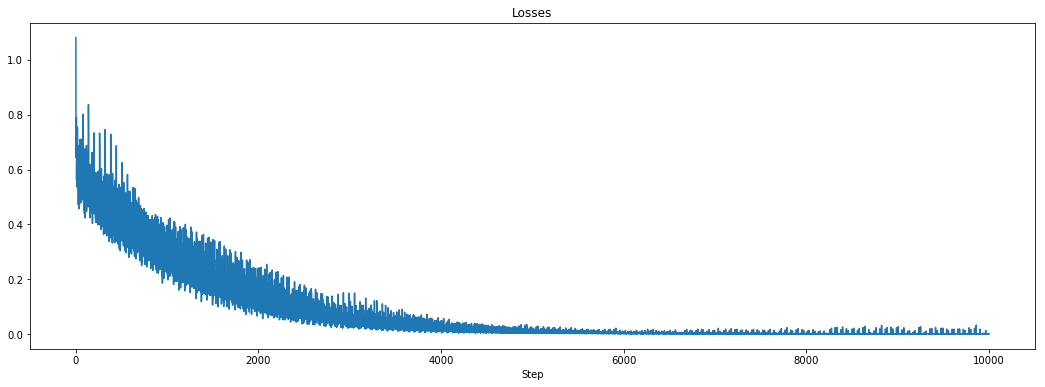

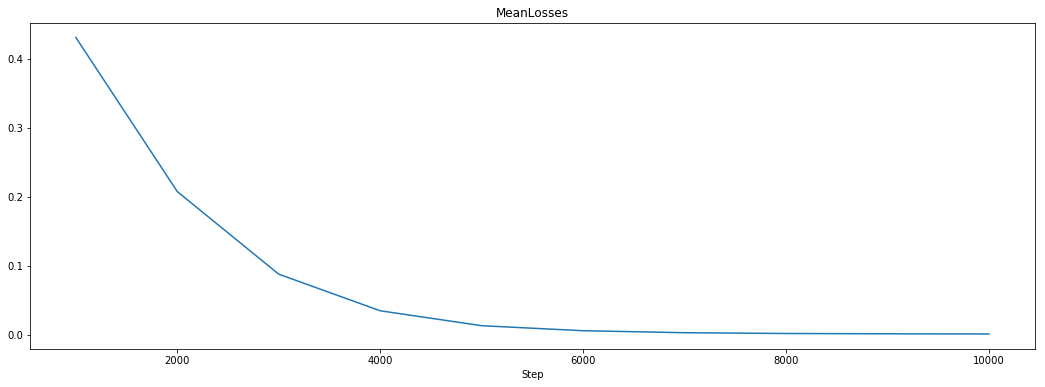

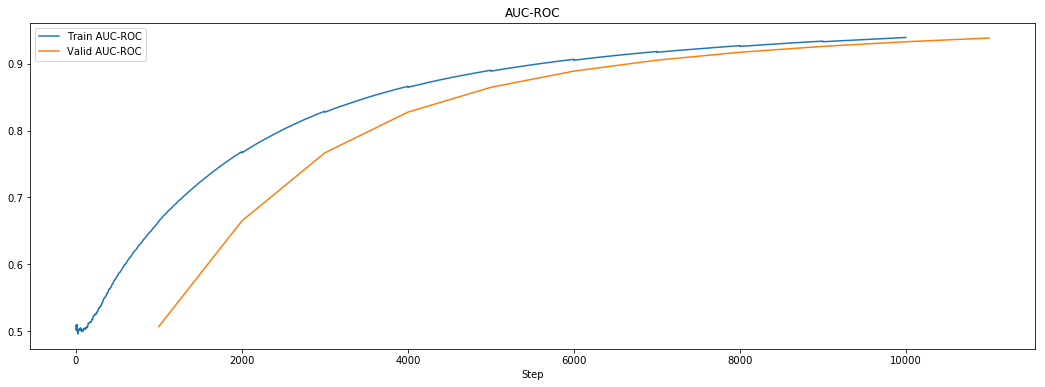

In [79]:
plot_results(losses[:], mean_losses[1:], train_aucs[1:], valid_aucs, frequency)

# Restore

In [ ]:
batch_size = test_size
test_batch_generator = LabeledBatchGenerator(X_test.as_matrix(), batch_size, comment_size, y_test.as_matrix())

with tf.Session(graph=graph) as session:
    saver.restore(session, "./checkpoint_dir/wordCNN")
    print("Model restored.")
    batches, labels = test_batch_generator.next()
    feed_dict = dict()
    for i in range(comment_size):
        feed_dict[tf_data[i]] = batches[i]
    train_labels_ = np.asarray(labels).astype('float').reshape(-1,1)
    feed_dict[tf_labels] = train_labels_
    feed_dict[tf_keep_prob] = 1.
    l, update, auc, predictions, _ = session.run([tf_loss, tf_update_oper, tf_auc_roc,
                                               tf_prediction, tf_optimizer],
                                              feed_dict=feed_dict)

INFO:tensorflow:Restoring parameters from /tmp/wordCNN
